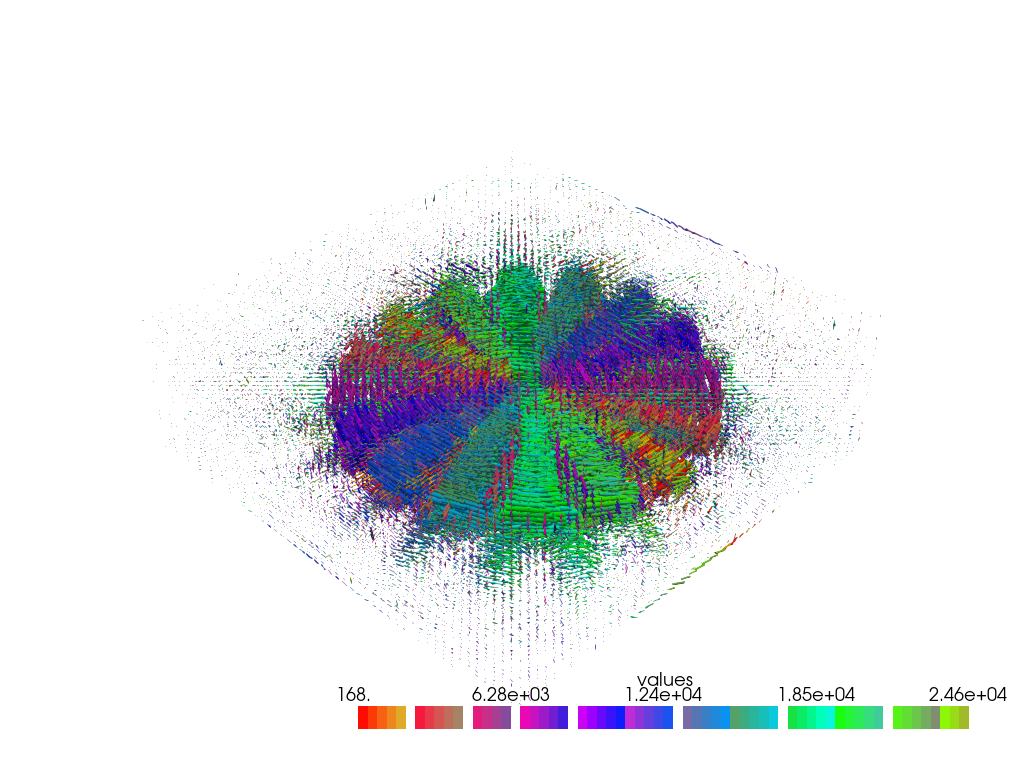

KeyboardInterrupt: 

In [6]:
import pyvista as pv
from pyvistaqt import BackgroundPlotter
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import glob
import cv2
import numpy as np
from scipy.ndimage import uniform_filter
import numpy.ma as ma

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from orientation_to_rgb import orientation_3D_to_rgb
import time
from numpy import linalg as LA

dataset = 'kaza'
ret_path = '3d_dataset/retardance3D/*'
azimuth_path = '3d_dataset/azimuth/*'
theta_path = '3d_dataset/theta/*'

ret_files = sorted(glob.glob(ret_path))
azimuth_files = sorted(glob.glob(azimuth_path))
theta_files = sorted(glob.glob(theta_path))

print()

# Generate colormap
spaces_th = 139
spaces_az = 157
th,ph = np.meshgrid(np.linspace(0,np.pi,spaces_th),np.linspace(0,np.pi,spaces_az))

if dataset == 'mouse':
    orientation_image = np.transpose(np.array([((ph + np.pi/2)%(2*np.pi))/2/np.pi, th, np.ones_like(th)]),(1,2,0))
else:
    orientation_image = np.transpose(np.array([ph/2/np.pi, th, np.ones_like(th)]),(1,2,0))
face_color = orientation_3D_to_rgb(orientation_image, interp_belt = 100/180*np.pi, sat_factor = 1)

mapping = np.linspace(0, spaces_th*spaces_az - 1, spaces_th*spaces_az)
newcolors = np.zeros((spaces_th*spaces_az, 4))

for i in range(spaces_az):
    for j in range(spaces_th):
        color = face_color[i][j]
        newcolor = np.ones((4,))
        newcolor[:3] = color
        newcolors[mapping == (i*spaces_az + j)] = newcolor

# Make the colormap from the listed colors
my_colormap = ListedColormap(newcolors)

line_az = np.linspace(0,np.pi,spaces_az)
line_th = np.linspace(0,np.pi,spaces_th)
iwidth_az = line_az[1] - line_az[0]
iwidth_th = line_th[1] - line_th[0]

linelength=20
denoise_weight=5
filter_size=(6, 6, 3)
anisotropy_scale=0.3
z_stack=96
spacing_xy=6
spacing_z=3
radius_scale=0.05
height_scale=0.7
colormap=my_colormap
neg_retardance=False
denoise=False

N_z = z_stack
ret = []
azimuth = []
theta = []
for i in range(N_z):
    ret.append(cv2.imread(ret_files[i], -1).astype('float32'))
    azimuth.append(cv2.imread(azimuth_files[i], -1).astype('float32'))
    theta.append(cv2.imread(theta_files[i], -1).astype('float32'))

ret = np.transpose(np.array(ret),(1,2,0))/10000
azimuth = np.transpose(np.array(azimuth),(1,2,0))/18000*np.pi
theta = np.transpose(np.array(theta),(1,2,0))/18000*np.pi

anisotropy= anisotropy_scale*np.abs(ret)

f_1c = anisotropy*linelength*(np.sin(theta)**2)*np.cos(2*azimuth)
f_1s = anisotropy*linelength*(np.sin(theta)**2)*np.sin(2*azimuth)
f_2c = anisotropy*linelength*np.sin(2*theta)*np.cos(azimuth)
f_2s = anisotropy*linelength*np.sin(2*theta)*np.sin(azimuth)

if denoise:
    f_1c_denoised = denoise_tv_chambolle(f_1c, weight=denoise_weight)
    f_1s_denoised = denoise_tv_chambolle(f_1s, weight=denoise_weight)
    f_2c_denoised = denoise_tv_chambolle(f_2c, weight=denoise_weight)
    f_2s_denoised = denoise_tv_chambolle(f_2s, weight=denoise_weight)
else:
    f_1c_denoised = f_1c
    f_1s_denoised = f_1s
    f_2c_denoised = f_2c
    f_2s_denoised = f_2s

f_1c_smooth = uniform_filter(f_1c_denoised, filter_size)
f_1s_smooth = uniform_filter(f_1s_denoised, filter_size)
f_2c_smooth = uniform_filter(f_2c_denoised, filter_size)
f_2s_smooth = uniform_filter(f_2s_denoised, filter_size)

reg_ret_ap = 0.00001

if not neg_retardance:
    azimuth_n = (np.arctan2(f_1s_smooth, f_1c_smooth)/2)%np.pi
    del_f_sin_square_n = f_1s_smooth*np.sin(2*azimuth_n) + f_1c_smooth*np.cos(2*azimuth_n)
    del_f_sin2theta_n = f_2s_smooth*np.sin(azimuth_n) + f_2c_smooth*np.cos(azimuth_n)
    theta_n = np.arctan2(2*del_f_sin_square_n, del_f_sin2theta_n)
    retardance_ap_n = del_f_sin_square_n * np.sin(theta_n)**2 / (np.sin(theta_n)**4 + reg_ret_ap)
else:
    azimuth_n = (np.arctan2(-f_1s_smooth, -f_1c_smooth)/2)%np.pi
    del_f_sin_square_n = f_1s_smooth*np.sin(2*azimuth_n) + f_1c_smooth*np.cos(2*azimuth_n)
    del_f_sin2theta_n = f_2s_smooth*np.sin(azimuth_n) + f_2c_smooth*np.cos(azimuth_n)
    theta_n = np.arctan2(-2*del_f_sin_square_n, -del_f_sin2theta_n)
    retardance_ap_n = del_f_sin_square_n * np.sin(theta_n)**2 / (np.sin(theta_n)**4 + reg_ret_ap)

USmooth = retardance_ap_n*np.cos(azimuth_n)*np.sin(theta_n)
VSmooth = retardance_ap_n*np.sin(azimuth_n)*np.sin(theta_n)
WSmooth = retardance_ap_n*np.cos(theta_n)

nY, nX, nZ = USmooth.shape
y, x, z = np.mgrid[0:nY,0:nX,0:nZ]

# Plot sparsely sampled vector lines
Plotting_X = x[::-spacing_xy, ::spacing_xy, ::spacing_z]
Plotting_Y = y[::-spacing_xy, ::spacing_xy, ::spacing_z]
Plotting_Z = z[::-spacing_xy, ::spacing_xy, ::spacing_z]
Plotting_U = USmooth[::-spacing_xy, ::spacing_xy, ::spacing_z]
Plotting_V = VSmooth[::-spacing_xy, ::spacing_xy, ::spacing_z]
Plotting_W = WSmooth[::-spacing_xy, ::spacing_xy, ::spacing_z]
Plotting_theta = theta_n[::-spacing_xy, ::spacing_xy, ::spacing_z]
Plotting_azimuth = azimuth_n[::-spacing_xy, ::spacing_xy, ::spacing_z]

azimuth_list = np.empty((Plotting_X.size, 1))
azimuth_list[:, 0] = Plotting_azimuth.ravel('F')

theta_list =  np.empty((Plotting_X.size, 1))
theta_list[:, 0] = Plotting_theta.ravel('F')

points = np.empty((Plotting_X.size, 3))
points[:, 0] = Plotting_X.ravel('F')
points[:, 1] = Plotting_Y.ravel('F')
points[:, 2] = Plotting_Z.ravel('F')

directions = np.empty((Plotting_X.size, 3))
directions[:, 0] = Plotting_U.ravel('F')
directions[:, 1] = Plotting_V.ravel('F')
directions[:, 2] = Plotting_W.ravel('F')

pos_x_list = np.ceil((azimuth_list - line_az[0]) / iwidth_az)
pos_y_list = np.ceil((theta_list - line_th[0]) / iwidth_th)
scalars = pos_x_list*spaces_az + pos_y_list

point_cloud = pv.PolyData(points)
point_cloud['vectors'] = directions
point_cloud['values'] = scalars
arrows = point_cloud.glyph(orient='vectors', scale=True, factor=5, geom=pv.Cylinder(radius=radius_scale, height=height_scale, resolution=200))

filename = "viz_3d_denoised.mp4"
pv.set_plot_theme("document")
plotter = pv.Plotter()
plotter.open_movie(filename)
plotter.add_mesh(arrows, scalars='values', cmap=my_colormap)

#     cpos = [(41914.98405034885, 45261.74263508663, 33163.87155659542),
#             (8751.112493753433, 12097.871078491211, 0.0),
#             (0.0, 0.0, 1.0)]
#cpos = [(598.635899228783, 618.3063588568882, 496.33323602172896),
#        (139.62683308124542, 159.2972927093506, 37.324169874191284),
#        (0.0, 0.0, 1.0)]
#plotter.camera_position = cpos
plotter.enable_anti_aliasing()
plotter.enable_depth_peeling(number_of_peels=4)
plotter.show(auto_close=False)
#plotter.write_frame()

for i in range(200):
#         cpos = [(598.635899228783, 618.3063588568882, 496.33323602172896 + i*5),
#                 (139.62683308124542, 159.2972927093506, 37.324169874191284),
#                 (0.0, 0.0, 1.0)]
    cpos = [(41914.98405034885, 45261.74263508663, 33163.87155659542 + i*100),
            (8751.112493753433, 12097.871078491211, 0.0),
            (0.0, 0.0, 1.0)]
    plotter.camera_position = cpos
    plotter.write_frame()  # Write this frame

for j in range(200):
#         cpos = [(598.635899228783, 618.3063588568882 - j*5, 496.33323602172896 + i*5),
#                 (139.62683308124542, 159.2972927093506, 37.324169874191284),
#                 (0.0, 0.0, 1.0)]
    cpos = [(41914.98405034885, 45261.74263508663 - j*100, 33163.87155659542 + i*100),
            (8751.112493753433, 12097.871078491211, 0.0),
            (0.0, 0.0, 1.0)]
    plotter.camera_position = cpos
    plotter.write_frame()  # Write this frame

for k in range(100):
    cpos = [(41914.98405034885, 45261.74263508663 - j*100, 33163.87155659542 + i*100),
            (8751.112493753433, 12097.871078491211, 0.0),
            (0.0 + k*0.005, 0.0 + k*0.005, 1.0 + k*0.005)]
    plotter.camera_position = cpos
    plotter.write_frame()  # Write this frame

plotter.close()

In [24]:
np.min(anisotropy)

0.0

In [8]:
mx = ma.masked_array(anisotropy, anisotropy > 1)

In [9]:
mx

masked_array(
  data=[[[0.15498000383377075, 0.10569000244140625, 0.11760000139474869,
          ..., 0.1406400054693222, 0.15630000829696655,
          0.16812001168727875],
         [0.06969000399112701, 0.11994000524282455, 0.06978000700473785,
          ..., 0.10653000324964523, 0.1257300078868866,
          0.13983000814914703],
         [0.04529999941587448, 0.015270001254975796,
          0.05838000401854515, ..., 0.04163999855518341,
          0.0630900040268898, 0.07728000730276108],
         ...,
         [0.09435000270605087, 0.08175000548362732, 0.06447000056505203,
          ..., 0.057120002806186676, 0.09588000178337097,
          0.12387000769376755],
         [0.07095000147819519, 0.07310999929904938, 0.07914000004529953,
          ..., 0.07953000068664551, 0.08688000589609146,
          0.09387000650167465],
         [0.06129000335931778, 0.07155000418424606, 0.0913500040769577,
          ..., 0.09579000622034073, 0.07988999783992767,
          0.07452000677585602]],



In [16]:
y = ma.array([1, 2, 3], mask = [0, 1, 0], fill_value=0)

In [19]:
y = np.array([1,2,3])

In [20]:
y[y > 1] = 0

In [21]:
y

array([1, 0, 0])